# Assignment 1: Adaptive Signal Processing

## Comparison of LMS, $\epsilon$- NLMS and RLS algorithms

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Defining the problem

We will be comparing evolution of mean squared error for linear channel estimation by LMS, $\epsilon$-NLMS and RLS algorithms

The specifications of the problem are:

Channel impulse response:

$H(z) = 1+0.5 z^{-1}-z^{-2}+2z^{-3}$

Input is white with unit variance and of length 600 samples

Number of ensembles to average over: 300

In [2]:
M = 4 #Channel size
N = 600 #Iterations
n_ensembles = 300 #Number of ensembles

In [3]:
C = np.array([1,0.5,-1,2])

Borrowing notation from Adaptive Filters by Ali H Sayed, section 8.1, we generate the data from the following relation:

$d = u w + v$

Here d is a column vector, u is a 2 dimensional matrix, w is a column vector and v is AWGN random vector with variance $\sigma_v^2$

For our problem of channel estimation, w is simply the channel impulse response and u is contains time embedded input stacked as rows(i.e. matrix form for linear convolution). $\sigma_v^2 = 0.01$

We will start with an initial guess of zero for $w$ ($w_{-1} = 0^T$) and see how error(prediction) evolves with iterations for the three algorithms. Each algorithm is stochastic, since we do not have complete knowledge of the gradient.

In [4]:
X = np.random.randn(n_ensembles,N)
U = np.zeros((n_ensembles,N,M))
U[:,:,0] = X[:,:]
U[:,1:,1] = X[:,0:-1]
U[:,2:,2] = X[:,0:-2]
U[:,3:,3] = X[:,0:-3]
D = U@C+0.1*np.random.randn(n_ensembles,N)

### Least Mean Squares

For LMS, the update rule is given by:

$e_i = d_i-u_i w_{i-1}$

$w_i = w_{i-1}+\mu u_i^H e_i$

Here d_i is a scalar, the $i^{th}$ of column vector d or value of d[n] at instant i. $w_i$ is our guess at time instant i and $u_i$ is the ith row of matrix u. $\mu$ is the step size for descent.

This is a stochastic algorithm where the values for correlation matrices of u and of u with d are taken from instantaneous values.

Code for the LMS algorithm:

In [5]:
# LMS
mu = 0.01
w_lms = np.zeros((n_ensembles,M,N+1))
err_lms = np.zeros((n_ensembles,N))
for n in range(n_ensembles):
    for i in range(N):
        err_lms[n,i] = D[n,i]-U[n,i]@w_lms[n,:,i]
        w_lms[n,:,i+1] = w_lms[n,:,i]+mu*((U[n,i].T)*err_lms[n,i])

temp = err_lms**2
mse_lms = np.mean(temp,axis=0)

### $\epsilon$-Normalised Least mean squares

The $\epsilon$ NLMS algorithm is based on a stochastic version of Newton's method. Newton's method is second order method for optimisation.

However, the regularisation sequence and step size sequence are taken to be constant in time. Also we again use instantaneous approximations for correlation matrices.

The update rule is given by

$e_i = d_i-u_iw_{i-1}$

$w_i = w_{i-1}+\frac{\mu}{\epsilon +||u_i||^2} u_i^H e_i$

Code:

In [6]:
#NLMS
mu_nlms = 0.2
eps_nlms = 0.001
w_nlms = np.zeros((n_ensembles,M,N+1))
err_nlms = np.zeros((n_ensembles,N))
for n in range(n_ensembles):
    for i in range(N):
        err_nlms[n,i] = D[n,i]-U[n,i]@w_nlms[n,:,i]
        w_nlms[n,:,i+1] = w_nlms[n,:,i]+(mu_nlms/(eps_nlms+U[n,i]@U[n,i].T))*((U[n,i].T)*err_nlms[n,i])

temp = err_nlms**2
mse_nlms = np.mean(temp,axis=0)


### Recursive Least Squares

Recursive Least squares, like $\epsilon$-NLMS is also derived from Newton's method, with step size and regularisation taken as constant throughout.

Newton's method, with constant step size and regularisation parameter

$ w_i = w_{i-1}+\mu (\epsilon I +R_u)^{-1}(R_{du}-R_u w_{i-1})$

Here the instantaneous approximation is used for $(R_{du}-R_u w_{i-1})$.

But for calculation of $R_u$, an exponentially weighted sample average is used.

The final update rule turns out to be:

$P_i = \lambda^{-1}[P_{i-1}-\frac{\lambda^{-1}P_{i-1}u_i^H u_iP_{i-1}}{1+\lambda^{-1}u_iP_{i-1}u_i^H}]$

$e_i = d_i-u_iw_{i-1}$

$w_i = w_{i-1}+P_i u_i^H e_i$

In [7]:
#RLS
lambda_rls = 0.995
eps_rls = 0.995
w_rls = np.zeros((n_ensembles,M,N+1))
err_rls = np.zeros((n_ensembles,N))

l_inv = 1/lambda_rls

P = np.zeros((n_ensembles,N+1,M,M))
for n in range(n_ensembles):
    P[n,0] = (1/eps_rls)*np.eye(M)
    
    for i in range(N):
        err_rls[n,i] = D[n,i]-U[n,i]@w_rls[n,:,i]
        P[n,i+1] = l_inv*(P[n,i]-(l_inv/(1+l_inv*U[n,i]@P[n,i]@U[n,i].T))*P[n,i]@np.outer(U[n,i],U[n,i])@P[n,i])
        w_rls[n,:,i+1] = w_rls[n,:,i]+P[n,i+1]@((U[n,i].T)*err_rls[n,i])

temp = err_rls**2
mse_rls = np.mean(temp,axis=0)


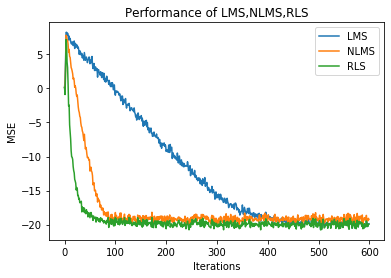

In [8]:
plt.plot(10*np.log10(mse_lms),label='LMS')
plt.plot(10*np.log10(mse_nlms),label='NLMS')
plt.plot(10*np.log10(mse_rls),label='RLS')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Performance of LMS,NLMS,RLS')
plt.savefig('q10.png')
plt.show()

### Observations:

1. We zoom in on the spike in error at the beginning.
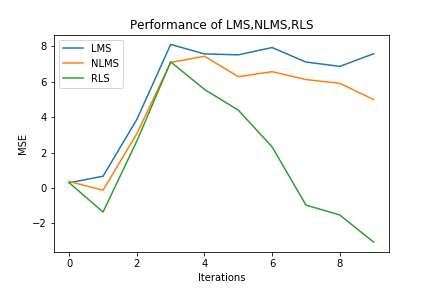

We notice that the error peaks at iteration number 3. Our channel is FIR of length 4, so when we write u in time embedded form with inputs stacked as rows(alternatively called matrix form for convolution), the first 4 entries(0 to 3) have some elements zeros because the input is 0 for negative time instants. After the input loads into the tap delay(length 4), the error starts decreasing after the buffer starts filling


2. From the original plot, shown below again for convenience;
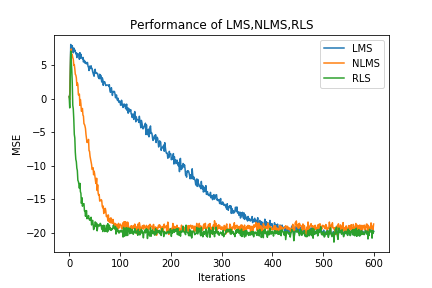

We notice that the performance for Recursive Least squares is better than NLMS which is much better than that for LMS. There is a clear improvement when looking at RLS and NLMS versus LMS. LMS is based on stochastic gradient descent and is a first order method, while the other two are based on a stochastic version of Newton's method, which is second order and uses curvature information, and hence show dramatic improvements over LMS. While NLMS uses instantaneous approximation for autocorrelation matrix of u, RLS uses a weighted sample average, which gives it the advantage of using past information as well. The tradeoff is increased computational complexity, which is higher for RLS followed by NLMS and then LMS

## Simulations for steady state performance for LMS

### Theory

The notation used here is same as in previous problems.
The exact expression for steady state excess mean squared error, when using LMS algorithm, is given by:

$\zeta^{LMS} = \lim_{i\to\infty}\frac{\mu}{2}[E||u_i||^2|e_a(i)|^2+\sigma_v^2Tr(R_u)]$

Here $e_a = e(i)-v(i)$

We will be using 2 approximations of this exact expression, small step size and separation principle.

For small step sizes, one neglects the contribution of the first term and the resulting EMSE becomes

$\zeta^{LMS} = \frac{\mu \sigma_v^2Tr(R_u)}{2}$

The second approximation assumes that at steady state, $||u_i||^2$ is independent of $e_a(i)$, which leads to the following expression

$\zeta^{LMS} = \frac{\mu \sigma_v^2Tr(R_u)}{2-\mu Tr(R_u)}$

One can see that the first approximation is a limiting case of the second mathematically, although both are derived under seemingly different assumptions(assumption 2 encompasses 1 actually).

Therefore, one expects the plots for second expression to be closer to simulations over a wider range of step size, something we observe later.

### Simulation for regressors without shift structure

For the first problem, we have to generate data corresponding to regressors with no shift structure.

The assumptions are taken from model 15.16 from the textbook.

We generate the data as:

$d = u w_o +v$

Since the model 15.16 assumes existence of $w_o$, we generate $w_o$ randomly. Upon experimentation with different values for $w_o$, we found no change in the plots for mean squared error, so we proceed with a randomly chosen vector.

Also here the regressors do not have shift structure, each row of u is a random vector independent of the other. Furthermore, we given that the eigenvalue spread of autocorrelation matrix of u is 5. Similarity transformations do not affect the trace and the steady state error, so we take $R_u$ to be diagonal whose entries are linearly spaced between 1 and 5.

Important point to note here again is that we need to add an extra $sigma_v^2$ to the EMSE, which is the excess mean squred error, to get mean squared error.

With this model, we proceed with the code below

In [9]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

In [10]:
num_iter = 4*10**5
num_ensembles = 100
sigma_v = np.sqrt(0.001)
M = 10
w_o = 3*np.random.randn(M)

In [11]:
mu = np.logspace(-4,-2,11)
R_u_diag = np.linspace(1,5,M)
err_lms = np.zeros((len(mu),num_iter))

w_lms = np.zeros((len(mu),num_ensembles,M))

for i in range(num_iter):
    u_iter = np.random.randn(len(mu),num_ensembles,M)
    u_iter = u_iter*np.sqrt(R_u_diag)
    
    d_iter = np.sum(u_iter*w_o,axis=2)+sigma_v*np.random.randn(len(mu),num_ensembles)
    
    pred_temp = np.sum(u_iter*w_lms,axis=2)
    err_temp = d_iter-pred_temp
    
    err_lms[:,i] = np.mean(err_temp**2,axis=1)
    
    vector_corr_temp = mu*(np.swapaxes(u_iter,0,2))
    
    w_lms+=np.swapaxes(vector_corr_temp*(err_temp.T),0,2)
err_lms_exp = np.mean(err_lms[0:,-5000:],axis=1)

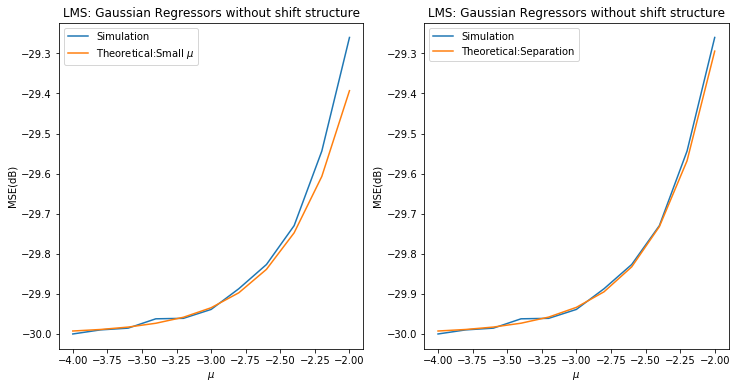

In [12]:
err_lms_small_mu = mu*(sigma_v**2)*np.sum(R_u_diag)/2+(sigma_v)**2
err_lms_separation = mu*(sigma_v**2)*np.sum(R_u_diag)/(2-mu*np.sum(R_u_diag))+(sigma_v)**2

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(np.log10(mu),10*np.log10(err_lms_exp),label='Simulation')
ax[0].plot(np.log10(mu),10*np.log10(err_lms_small_mu),label='Theoretical:Small '+r'$\mu$')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel('MSE(dB)')
ax[0].set_title('LMS: Gaussian Regressors without shift structure')
ax[0].legend()

ax[1].plot(np.log10(mu),10*np.log10(err_lms_exp),label='Simulation')
ax[1].plot(np.log10(mu),10*np.log10(err_lms_separation),label='Theoretical:Separation')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel('MSE(dB)')
ax[1].set_title('LMS: Gaussian Regressors without shift structure')
ax[1].legend()

plt.savefig('noshiftstr.png')
plt.show()

### Simulation for regressors with shift structure

Again, here too, we take $w_o$ to be a randomly generate row vector as before.

But now, $u_i$ are regressors with shift structure. Each $u_i$ is generated from a tap delay line from a sequence $u(i)$. u(i) is generated from passing an iid white sequence of unit variance through an IIR filter.

$u(i)-au(i-1) = \sqrt{1-a^2}s(i)$

Important point to note here again is that we need to add an extra $sigma_v^2$ to the EMSE, which is the excess mean squred error, to get mean squared error.

Code:

In [13]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

In [14]:
num_iter = 10**6
num_ensembles = 300
sigma_v = np.sqrt(0.001)
M = 10
w_o = 3*np.random.randn(M)

In [15]:
mu = np.logspace(-4,-2,11)
a = 0.8
c_s = np.sqrt(1-a**2)

err_lms = np.zeros((len(mu),num_iter))
w_lms = np.zeros((len(mu),num_ensembles,M))
u_iter = np.zeros((len(mu),num_ensembles,M))

for i in range(num_iter):
    u_new = a*u_iter[:,:,0]+c_s*np.random.randn(len(mu),num_ensembles)
    u_temp = np.zeros((len(mu),num_ensembles,M))
    u_temp[:,:,0] = u_new
    u_temp[:,:,1:] = u_iter[:,:,0:-1]
    u_iter = u_temp
    
    d_iter = np.sum(u_iter*w_o,axis=2)+sigma_v*np.random.randn(len(mu),num_ensembles)
    
    pred_temp = np.sum(u_iter*w_lms,axis=2)
    err_temp = d_iter-pred_temp
    
    err_lms[:,i] = np.mean(err_temp**2,axis=1)
    
    vector_corr_temp = mu*(np.swapaxes(u_iter,0,2))
    
    w_lms+=np.swapaxes(vector_corr_temp*(err_temp.T),0,2)
err_lms_exp = np.mean(err_lms[0:,-5000:],axis=1)

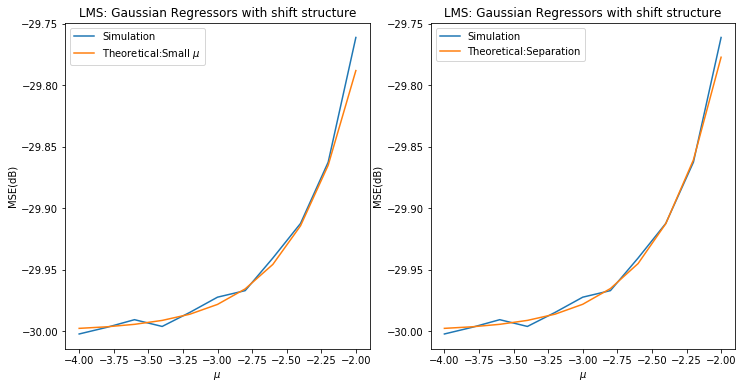

In [16]:
i = np.arange(0,M,1)
j = np.arange(0,M,1)
I, J = np.meshgrid(i,j)
R_u = a**(np.abs(I-J))

err_lms_small_mu = mu*(sigma_v**2)*np.trace(R_u)/2+(sigma_v)**2
err_lms_separation = mu*(sigma_v**2)*np.trace(R_u)/(2-mu*np.trace(R_u))+(sigma_v)**2

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(np.log10(mu),10*np.log10(err_lms_exp),label='Simulation')
ax[0].plot(np.log10(mu),10*np.log10(err_lms_small_mu),label='Theoretical:Small '+r'$\mu$')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel('MSE(dB)')
ax[0].set_title('LMS: Gaussian Regressors with shift structure')
ax[0].legend()

ax[1].plot(np.log10(mu),10*np.log10(err_lms_exp),label='Simulation')
ax[1].plot(np.log10(mu),10*np.log10(err_lms_separation),label='Theoretical:Separation')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel('MSE(dB)')
ax[1].set_title('LMS: Gaussian Regressors with shift structure')
ax[1].legend()

plt.savefig('shiftstr.png')
plt.show()

### Observations:

1. The first observation we can make regarding both models is that the separation principle approximation gives better results compared to small step size approximation. As explained earlier, the small step size approximation mathematically corresponds to limit of separation principle approximation, so while it is very accurate at small step size, it differs at larger step sizes. The second approximation provides a better fit over larger ranges.
2. The second observation is that for the data corresponding to regressors with shift structure, the two approximations give better fits than they did for the case with no shift structure. We try to give a reason for this here:

    The good fit for the expression for small step sizes indicates that $|e_a(i)|$ becomes very small so that the first term in the espression for exact EMSE can be neglected, and it also becomes independent of $||u_i||^2$ at steady state. But why does this occur for inputs with shift structure?
    
    First of all we have to realise that LMS is a stochastic algorithm. We do not have access to the correlation matrices and have to calculate these. Not only that our estimate is based on the instantaneous sample correlation, which itself is a random matrix. When we have a guess for w at some stage, the degree to which we get an improved estimate depends on how much information is shared between adjacent values of $u_i$.
    
    For the case of input with no shift structure each $u_i, u_j$ were independent for $i\neq j$. For the case of input with shift structure, since the input is "slid" across(tap delay), there is correlation between not only adjacent rows in u matrix($u_i, u_i+1$), but all rows within M of each other share information(M is size of tap delay). This extra information in form of correlation helps us achieve a better performance in terms of error, which leads to smaller values of $|e_a(i)|$ at steady state.
    
    If one thinks of w itself as a random vector at steady state, one could see the process as a Markov process. The probability that in the next iteration the entries of w will deviate more is higher if the $u_i$ does not share any information with $u_{i-1}$ than if $u_i$ and $u_{i-1}$ had common data(shift structure), in which case the new estimate is less likely to deviate more from original.
    
    What this results in at steady state is lesser variance in estimate of w in shift structure case vs one with no shift structure, which translates to lesser error and hence lesser value of $|e_a(i)|$.
    
    For this reason, in the second model, both theoretical expressions are a better fit compared to the case of no shift structure.